In [29]:
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import openpyxl
from openpyxl.styles import PatternFill, Font
import pandas as pd
import numpy as np
import itertools
import os
import statsmodels.api as sm_stats           
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import squarify

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# =============================================================================
# CẤU HÌNH HIỂN THỊ DỮ LIỆU
# =============================================================================
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# =============================================================================
# CẤU HÌNH FOLDER LƯU KẾT QUẢ
# =============================================================================
OUTPUT_FOLDER = "KET_QUA"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"Đã tạo folder mới: {OUTPUT_FOLDER}")
else:
    print(f"Sẽ lưu kết quả vào folder: {OUTPUT_FOLDER}")

Đã tạo folder mới: KET_QUA


In [30]:
# =============================================================================
# CẤU HÌNH ĐƯỜNG DẪN FILE
# =============================================================================
excel_file = 'HNXINDEX30_STOCKS_Lichsu_Clean.xlsx'
index_excel_file = 'HNXINDEX_Lichsu_Clean.xlsx'

# =============================================================================
# MÃ CỔ PHIẾU HNX-INDEX 30
# =============================================================================
hnx_stock_sheets = [
    'DVM', 'DP3', 'CAP', 'DTD', 'CEO', 'BVS', 'DHT', 'DXP', 'HGM', 'HUT',
    'IDC', 'L18', 'L14', 'IDV', 'LAS', 'LHC', 'MBS', 'NTP', 'PSD', 'PLC',
    'PVB', 'PVI', 'PVC', 'PVS', 'SHS', 'SLS', 'TMB', 'TNG', 'VC3', 'VCS'
]

list_prices = []
list_volumes = []

print("--- BẮT ĐẦU TẢI DỮ LIỆU (GIÁ & VOLUME) ---")

# =============================================================================
# ĐỌC DỮ LIỆU CỔ PHIỂU
# =============================================================================
for sheet in hnx_stock_sheets:
    try:
        df = pd.read_excel(excel_file, sheet_name=sheet,
                           usecols=['Date', 'Close_Adj', 'Volume'],
                           parse_dates=['Date'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')

        price_series = df[['Close_Adj']].rename(columns={'Close_Adj': sheet})
        vol_series = df[['Volume']].rename(columns={'Volume': sheet})

        list_prices.append(price_series)
        list_volumes.append(vol_series)
        print(f"Đã tải: {sheet}")

    except Exception as e:
        print(f"Lỗi khi đọc sheet {sheet}: {e}")

# =============================================================================
# ĐỌC DỮ LIỆU CHỈ SỐ
# =============================================================================
print("\nĐang tải dữ liệu HNX-INDEX...")
try:
    df_index = pd.read_excel(index_excel_file, sheet_name='HNX-INDEX',
                             usecols=['Date', 'Close_Adj'], parse_dates=['Date'])

    df_index['Date'] = pd.to_datetime(df_index['Date'])
    df_index = df_index.set_index('Date')

    index_price = df_index[['Close_Adj']].rename(columns={'Close_Adj': 'HNXINDEX'})
    list_prices.append(index_price)
    print("Đã tải: HNXINDEX")

except Exception as e:
    print(f"Lỗi khi đọc sheet HNX-INDEX: {e}")

# =============================================================================
# GỘP CHỈ SỐ VÀO DỮ LIỆU CỔ PHIẾU
# =============================================================================
if not list_prices:
    raise Exception("KHÔNG TẢI ĐƯỢC DỮ LIỆU NÀO!")

price_data = pd.concat(list_prices, axis=1).sort_index()
price_data = price_data.loc['2020-01-01':]
price_data_final = price_data.ffill()

volume_data = pd.concat(list_volumes, axis=1).sort_index()
volume_data = volume_data.loc['2020-01-01':]
volume_data_final = volume_data.fillna(0)

# =============================================================================
# LỌC MÃ CÓ ĐỦ DỮ LIỆU
# =============================================================================
min_obs = int(len(price_data_final) * 0.2)
price_data_final = price_data_final.dropna(axis=1, thresh=min_obs)
valid_stocks = [c for c in price_data_final.columns if c != 'HNXINDEX']
volume_data_final = volume_data_final[valid_stocks]
cols_price = ['HNXINDEX'] + sorted(valid_stocks)
price_data_final = price_data_final[cols_price]

print("\n--- TÍNH RETURN NHIỀU KHUNG THỜI GIAN ---")
returns_daily = price_data_final.pct_change().iloc[1:]
returns_weekly = price_data_final.resample('W').last().pct_change().iloc[1:]
returns_monthly = price_data_final.resample('M').last().pct_change().iloc[1:]
returns_yearly = price_data_final.resample('Y').last().pct_change().iloc[1:]
print("Return daily / weekly / monthly / yearly đã tạo xong (Bảo toàn dữ liệu từ 2020).")

# =============================================================================
# SUMMARY STATS (GIÁ)
# =============================================================================
print("\n--- TẠO SUMMARY STATS ---")
summary_stats = price_data_final.describe().T
summary_stats["skew"] = price_data_final.skew()
summary_stats["kurtosis"] = price_data_final.kurtosis()

# =============================================================================
# STATS TRẢ VỀ 
# =============================================================================
returns_stats = returns_daily.describe().T
returns_stats["skew"] = returns_daily.skew()
returns_stats["kurtosis"] = returns_daily.kurtosis()

--- BẮT ĐẦU TẢI DỮ LIỆU (GIÁ & VOLUME) ---
Đã tải: DVM
Đã tải: DVM
Đã tải: DP3
Đã tải: DP3
Đã tải: CAP
Đã tải: CAP
Đã tải: DTD
Đã tải: DTD
Đã tải: CEO
Đã tải: CEO
Đã tải: BVS
Đã tải: BVS
Đã tải: DHT
Đã tải: DHT
Đã tải: DXP
Đã tải: DXP
Đã tải: HGM
Đã tải: HGM
Đã tải: HUT
Đã tải: HUT
Đã tải: IDC
Đã tải: IDC
Đã tải: L18
Đã tải: L18
Đã tải: L14
Đã tải: L14
Đã tải: IDV
Đã tải: IDV
Đã tải: LAS
Đã tải: LAS
Đã tải: LHC
Đã tải: LHC
Đã tải: MBS
Đã tải: MBS
Đã tải: NTP
Đã tải: NTP
Đã tải: PSD
Đã tải: PSD
Đã tải: PLC
Đã tải: PLC
Đã tải: PVB
Đã tải: PVB
Đã tải: PVI
Đã tải: PVI
Đã tải: PVC
Đã tải: PVC
Đã tải: PVS
Đã tải: PVS
Đã tải: SHS
Đã tải: SHS
Đã tải: SLS
Đã tải: SLS
Đã tải: TMB
Đã tải: TMB
Đã tải: TNG
Đã tải: TNG
Đã tải: VC3
Đã tải: VC3
Đã tải: VCS

Đang tải dữ liệu HNX-INDEX...
Đã tải: VCS

Đang tải dữ liệu HNX-INDEX...
Đã tải: HNXINDEX

--- TÍNH RETURN NHIỀU KHUNG THỜI GIAN ---
Return daily / weekly / monthly / yearly đã tạo xong (Bảo toàn dữ liệu từ 2020).

--- TẠO SUMMARY STATS ---
Đã tải:

Đã lưu ảnh: KET_QUA\1_Histogram_Returns.png


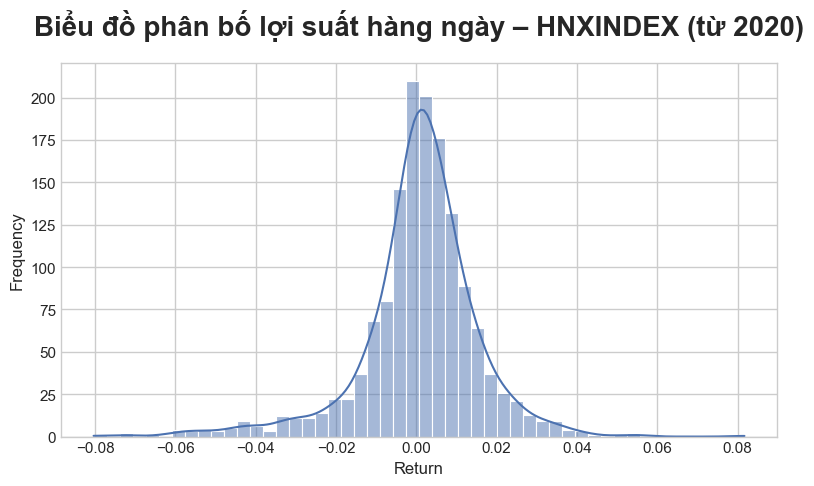

In [31]:
# =========================================
# HISTOGRAM 
# =========================================
plt.figure(figsize=(8,5))
sns.histplot(returns_daily['HNXINDEX'].dropna(), bins=50, kde=True)
plt.title("Biểu đồ phân bố lợi suất hàng ngày – HNXINDEX (từ 2020)", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()

img_path1 = os.path.join(OUTPUT_FOLDER, '1_Histogram_Returns.png')
plt.savefig(img_path1, dpi=300)
print(f"Đã lưu ảnh: {img_path1}")
plt.show()

Đã lưu ảnh: KET_QUA\2_Correlation_Heatmap.png


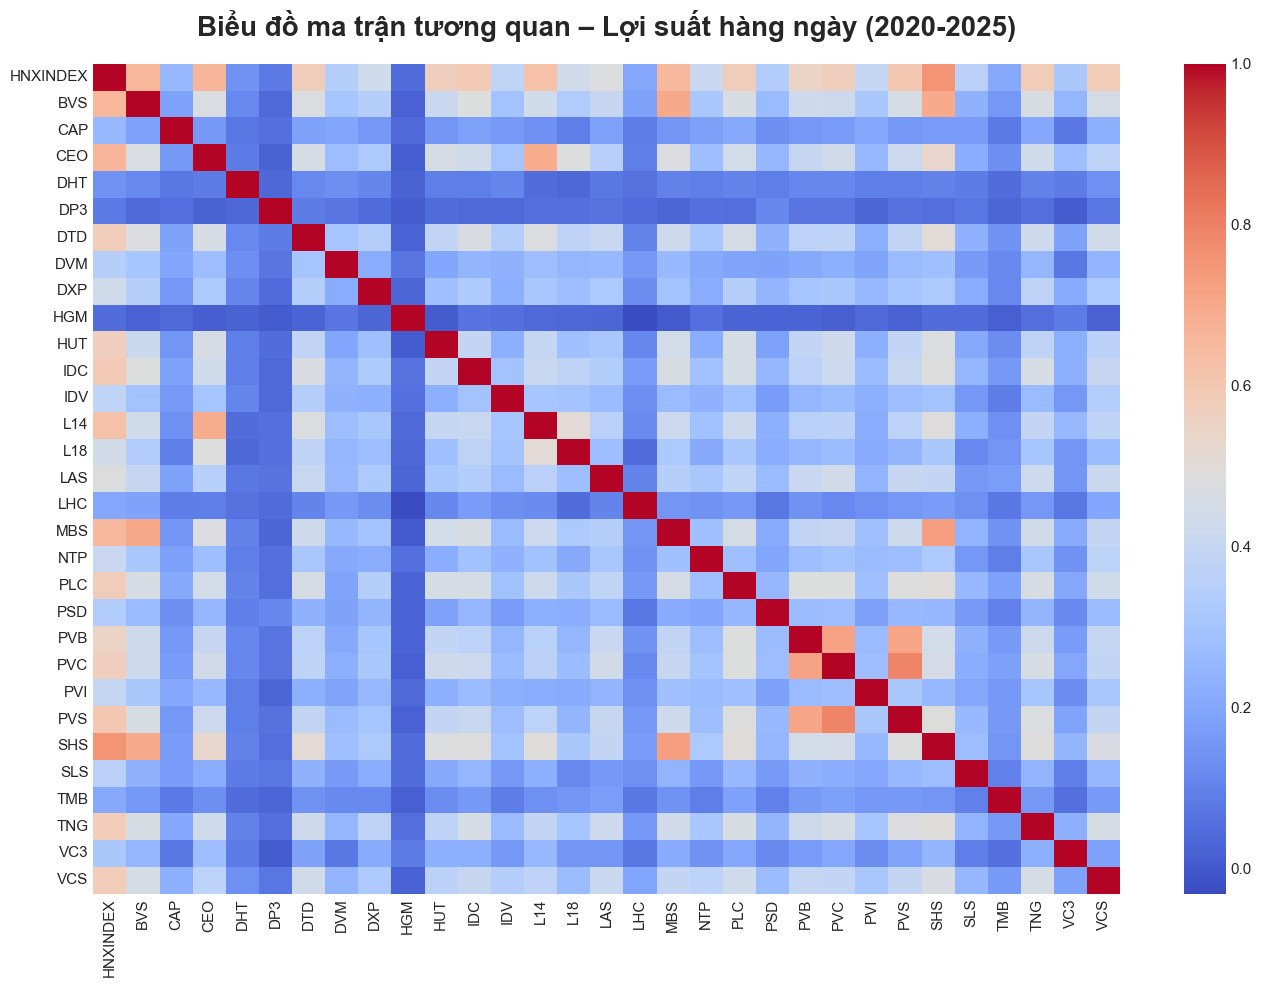


Đang xuất ra file Excel: HNX30_HNXINDEX_gop.xlsx

Đang xuất ra file Excel: KET_QUA\HNX30_HNXINDEX_gop.xlsx

Đang xuất ra file Excel: KET_QUA\HNX30_HNXINDEX_gop.xlsx

--- HOÀN TẤT XUẤT FILE Ở CẢ 2 VỊ TRÍ ---

--- HOÀN TẤT XUẤT FILE Ở CẢ 2 VỊ TRÍ ---


In [32]:
# =========================================
# HEATMAP 
# =========================================
corr_matrix = returns_daily.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Biểu đồ ma trận tương quan – Lợi suất hàng ngày (2020-2025)", fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()

img_path2 = os.path.join(OUTPUT_FOLDER, '2_Correlation_Heatmap.png')
plt.savefig(img_path2, dpi=300)
print(f"Đã lưu ảnh: {img_path2}")
plt.show()

# =========================================
# XUẤT EXCEL 
# =========================================
# Tạo DataFrame thống kê
summary = pd.DataFrame({
    'Mã': price_data_final.columns,
    'Số ngày Price': [price_data_final[col].count() for col in price_data_final.columns],
    'Start Date': [price_data_final[col].first_valid_index().date() for col in price_data_final.columns]
})

# Danh sách các đường dẫn cần lưu file
save_paths = [
    'HNX30_HNXINDEX_gop.xlsx',                          
    os.path.join(OUTPUT_FOLDER, 'HNX30_HNXINDEX_gop.xlsx') 
]

for path in save_paths:
    print(f"\nĐang xuất ra file Excel: {path}")
    with pd.ExcelWriter(path, engine='openpyxl') as writer:
        price_data_final.to_excel(writer, sheet_name='HNX30_Adjusted_Price')
        volume_data_final.to_excel(writer, sheet_name='HNX30_Volume')
        summary.to_excel(writer, sheet_name='Thống kê', index=False)
        summary_stats.to_excel(writer, sheet_name='Summary_Stats')
        returns_stats.to_excel(writer, sheet_name='Returns_Stats')
        corr_matrix.to_excel(writer, sheet_name='Correlation_Matrix')
        returns_daily.to_excel(writer, sheet_name='Returns_Daily')
        returns_weekly.to_excel(writer, sheet_name='Returns_Weekly')
        returns_monthly.to_excel(writer, sheet_name='Returns_Monthly')
        returns_yearly.to_excel(writer, sheet_name='Returns_Yearly')

print("\n--- HOÀN TẤT XUẤT FILE Ở CẢ 2 VỊ TRÍ ---")

Đang xử lý dữ liệu cho: SHS...
Hoàn tất: 306 tuần dữ liệu (từ 17/01/2020 → 21/11/2025)

BẮT ĐẦU DỰ BÁO THÁNG KẾ TIẾP
Ngày dữ liệu mới nhất: 21/11/2025 (tuần kết thúc thứ 6)
→ DỰ BÁO CHO THÁNG: 12/2025
------------------------------------------------------------
Đang tìm tham số ARIMA tối ưu...
Hoàn tất: 306 tuần dữ liệu (từ 17/01/2020 → 21/11/2025)

BẮT ĐẦU DỰ BÁO THÁNG KẾ TIẾP
Ngày dữ liệu mới nhất: 21/11/2025 (tuần kết thúc thứ 6)
→ DỰ BÁO CHO THÁNG: 12/2025
------------------------------------------------------------
Đang tìm tham số ARIMA tối ưu...
Model được chọn: ARIMA(1, 0, 0) (AIC: -722.0)

DỰ BÁO CHI TIẾT THÁNG 12/2025:
--------------------------------------------------
05/12/2025 (Tuần 1    ):  +0.40% → 23.1 ₫
Model được chọn: ARIMA(1, 0, 0) (AIC: -722.0)

DỰ BÁO CHI TIẾT THÁNG 12/2025:
--------------------------------------------------
05/12/2025 (Tuần 1    ):  +0.40% → 23.1 ₫
12/12/2025 (Tuần 2    ):  +1.04% → 23.3 ₫
19/12/2025 (Tuần 3    ):  +1.12% → 23.6 ₫
12/12/2025 (Tuầ

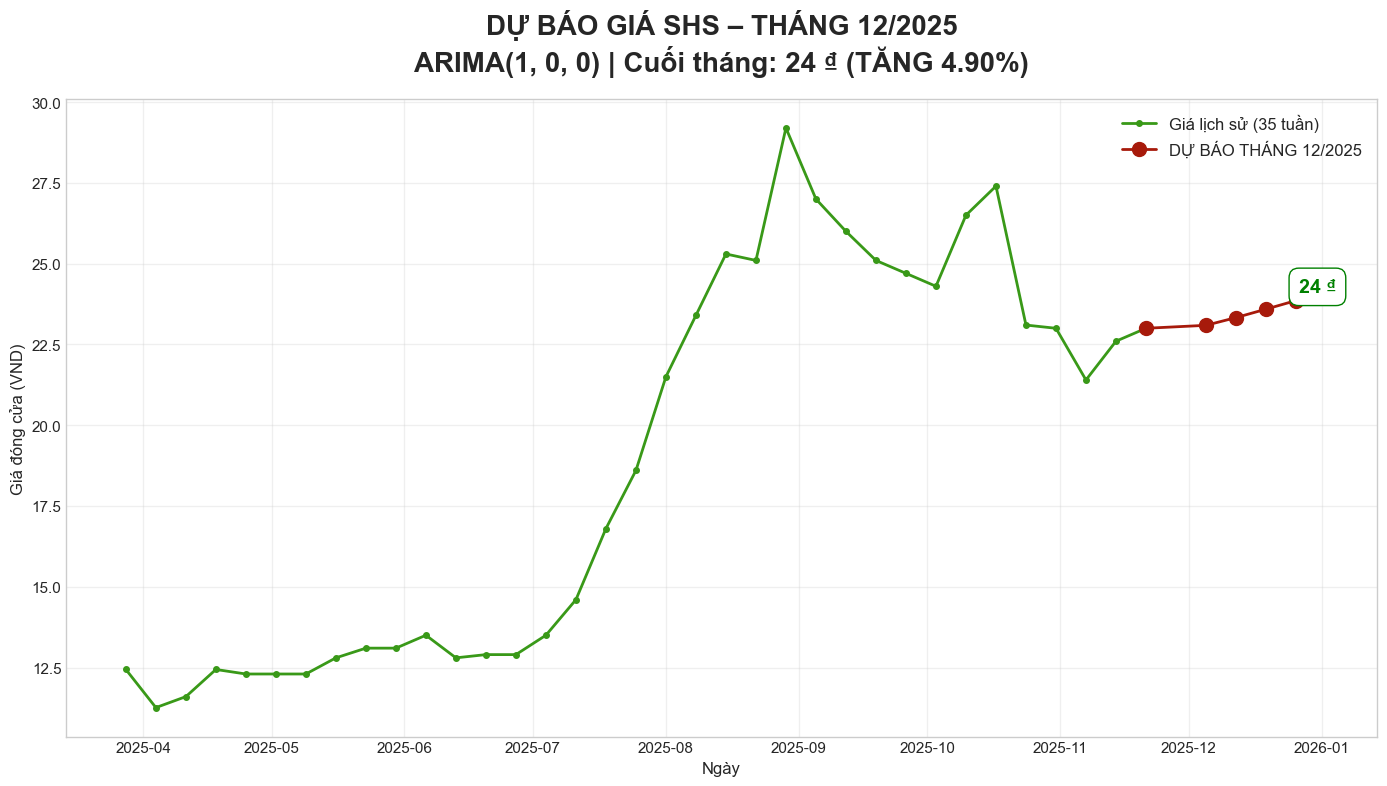


KẾT QUẢ DỰ BÁO THÁNG 12/2025
      Ngày  Giá dự báo (VND)
05/12/2025              23.1
12/12/2025              23.3
19/12/2025              23.6
26/12/2025              23.9
31/12/2025              24.1

→ Dự báo cuối tháng 12/2025: 24 ₫ (TĂNG 4.90%)

ĐÃ LƯU: output\DuBao_SHS_Thang_122025.xlsx

HOÀN TẤT 100%! Tất cả file đã lưu trong thư mục: output


In [33]:
# ==========================================
# ARIMA - DỰ BÁO GIÁ CỔ PHIẾU THÁNG KẾ TIẾP 
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import os
from statsmodels.tsa.arima.model import ARIMA

# Thư mục lưu kết quả
OUTPUT_FOLDER = "output"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ================== CẤU HÌNH ==================
CONFIG = {
    'stock_file_path': 'HNX30_HNXINDEX_gop.xlsx',
    'sheet_price': 'HNX30_Adjusted_Price',
    'bond_file_path': '10ybondyield_filled.xlsx',
    'sheet_bond': 'Sheet1',
    
    'target_stock': 'SHS',          
    'start_date': '2020-01-01',
    
    'p_range': range(0, 5),
    'd_range': [0, 1],
    'q_range': range(0, 5),
}

# ================== XỬ LÝ DỮ LIỆU ==================
def load_process_data(config):
    print(f"Đang xử lý dữ liệu cho: {config['target_stock']}...")
    try:
        df_price = pd.read_excel(config['stock_file_path'], sheet_name=config['sheet_price'])
        df_bond = pd.read_excel(config['bond_file_path'], sheet_name=config['sheet_bond'])

        for df in [df_price, df_bond]:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df.columns = df.columns.str.strip()

        df_raw = pd.DataFrame({'Price': df_price[config['target_stock']]})
        col_bond = 'LaiSuat' if 'LaiSuat' in df_bond.columns else df_bond.columns[0]
        df_raw = df_raw.join(df_bond[col_bond].rename("BondYield"), how='left')
        
        df_raw = df_raw.ffill().bfill()
        df_raw = df_raw[df_raw.index >= pd.to_datetime(config['start_date'])]

        df_weekly = df_raw.resample('W-FRI').agg({'Price': 'last', 'BondYield': 'mean'}).ffill()
        df_weekly['Return'] = df_weekly['Price'].pct_change()
        df_weekly['Bond_Pct'] = df_weekly['BondYield'].pct_change()
        df_weekly.replace([np.inf, -np.inf], 0, inplace=True)
        df_weekly['Lag_Bond'] = df_weekly['Bond_Pct'].shift(1)
        df_weekly.dropna(inplace=True)
        
        print(f"Hoàn tất: {len(df_weekly)} tuần dữ liệu (từ {df_weekly.index[0].strftime('%d/%m/%Y')} → {df_weekly.index[-1].strftime('%d/%m/%Y')})")
        return df_weekly
    except Exception as e:
        print(f"Lỗi xử lý dữ liệu: {e}")
        return None

# ================== TẠO NGÀY THÁNG KẾ TIẾP ==================
def generate_next_month_dates(last_date):
    current_year, current_month = last_date.year, last_date.month
    next_month = current_month + 1 if current_month < 12 else 1
    next_year = current_year + (1 if current_month == 12 else 0)
    
    start_next = pd.Timestamp(year=next_year, month=next_month, day=1)
    end_next = start_next + pd.offsets.MonthEnd(0)
    
    fridays = pd.date_range(start_next, end_next, freq='W-FRI')
    dates = fridays.union([end_next])  # Luôn có ngày cuối tháng
    return dates

# ================== DỰ BÁO THÁNG KẾ TIẾP ==================
def run_forecast_next_month(df, config):
    print("\n" + "="*60)
    print("BẮT ĐẦU DỰ BÁO THÁNG KẾ TIẾP")
    print("="*60)
    
    last_week = df.index[-1]
    next_month_str = (last_week + pd.offsets.MonthBegin(1)).strftime('%m/%Y')
    
    print(f"Ngày dữ liệu mới nhất: {last_week.strftime('%d/%m/%Y')} (tuần kết thúc thứ 6)")
    print(f"→ DỰ BÁO CHO THÁNG: {next_month_str}")
    print("-"*60)
    
    # Grid search ARIMA
    best_aic = np.inf
    best_order = (1,0,1)
    y = df['Return']
    X = df[['Lag_Bond']]
    
    print("Đang tìm tham số ARIMA tối ưu...")
    for p, d, q in itertools.product(config['p_range'], config['d_range'], config['q_range']):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = ARIMA(y, exog=X, order=(p,d,q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p,d,q)
        except:
            continue
    print(f"Model được chọn: ARIMA{best_order} (AIC: {best_aic:.1f})")

    # Chuẩn bị dự báo cuốn chiếu
    history_ret = list(df['Return'].values)
    history_exog = list(df['Lag_Bond'].values)
    avg_bond = df['Lag_Bond'].iloc[-100:].mean()
    
    price = df['Price'].iloc[-1]
    dates = generate_next_month_dates(last_week)
    
    forecast_prices = [price]
    forecast_dates = [last_week]
    
    print(f"\nDỰ BÁO CHI TIẾT THÁNG {next_month_str}:")
    print("-" * 50)
    
    for i, date in enumerate(dates, 1):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = ARIMA(history_ret, exog=np.array(history_exog).reshape(-1,1), order=best_order).fit()
        
        pred_ret = model.get_forecast(steps=1, exog=[[avg_bond]]).predicted_mean[0]
        
        price = price * (1 + pred_ret)
        forecast_prices.append(price)
        forecast_dates.append(date)
        
        history_ret.append(pred_ret)
        history_exog.append(avg_bond)
        
        label = "CUỐI THÁNG" if date.day > 25 else f"Tuần {i}"
        print(f"{date.strftime('%d/%m/%Y')} ({label:10}): {pred_ret*100:+6.2f}% → {price:,.1f} ₫")
    
    return pd.Series(forecast_prices, index=forecast_dates), best_order, next_month_str

# ================== KẾT QUẢ ==================
def plot_and_save(df, forecast_series, config, best_order, month_str):
    plt.figure(figsize=(14, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Lịch sử
    plt.plot(df['Price'].iloc[-35:], label='Giá lịch sử (35 tuần)', color='#399918', linewidth=2, marker='o', markersize=4)
    
    # Dự báo
    plt.plot(forecast_series.index, forecast_series, label=f'DỰ BÁO THÁNG {month_str}', 
             color="#a71a0b", linewidth=2, marker='o', markersize=10)
    
    start_p = forecast_series.iloc[0]
    end_p = forecast_series.iloc[-1]
    change = (end_p - start_p) / start_p * 100
    status = "TĂNG" if change > 0 else "GIẢM"
    color = 'green' if change > 0 else 'red'
    
    plt.title(f"DỰ BÁO GIÁ {config['target_stock']} – THÁNG {month_str}\n"
              f"ARIMA{best_order} | Cuối tháng: {end_p:,.0f} ₫ ({status} {abs(change):.2f}%)", 
              fontsize=20, fontweight='bold', pad=20)
    
    plt.ylabel("Giá đóng cửa (VND)", fontsize=12)
    plt.xlabel("Ngày", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.text(forecast_series.index[-1], end_p, f"{end_p:,.0f} ₫", 
             fontsize=14, fontweight='bold', color=color, ha='center',
             bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.5'))
    
    plt.tight_layout()
    filename = f"DuBao_{config['target_stock']}_Thang_{month_str.replace('/', '')}.png"
    plt.savefig(os.path.join(OUTPUT_FOLDER, filename), dpi=300, bbox_inches='tight')
    plt.show()
    
    # In kết quả
    print("\n" + "="*60)
    print(f"KẾT QUẢ DỰ BÁO THÁNG {month_str}")
    print("="*60)
    result = pd.DataFrame({
        'Ngày': forecast_series.index[1:].strftime('%d/%m/%Y'),
        'Giá dự báo (VND)': forecast_series.values[1:].round(1)
    })
    print(result.to_string(index=False))
    print(f"\n→ Dự báo cuối tháng {month_str}: {end_p:,.0f} ₫ ({status} {abs(change):.2f}%)")
    
    # Lưu Excel
    excel_file = os.path.join(OUTPUT_FOLDER, f"DuBao_{config['target_stock']}_Thang_{month_str.replace('/', '')}.xlsx")
    result.to_excel(excel_file, index=False)
    print(f"\nĐÃ LƯU: {excel_file}")
if __name__ == "__main__":
    df = load_process_data(CONFIG)
    if df is not None and len(df) >= 50:
        forecast_series, best_order, month_str = run_forecast_next_month(df, CONFIG)
        plot_and_save(df, forecast_series, CONFIG, best_order, month_str)
        print(f"\nHOÀN TẤT 100%! Tất cả file đã lưu trong thư mục: {OUTPUT_FOLDER}")
    else:
        print("Dữ liệu không đủ để dự báo!")

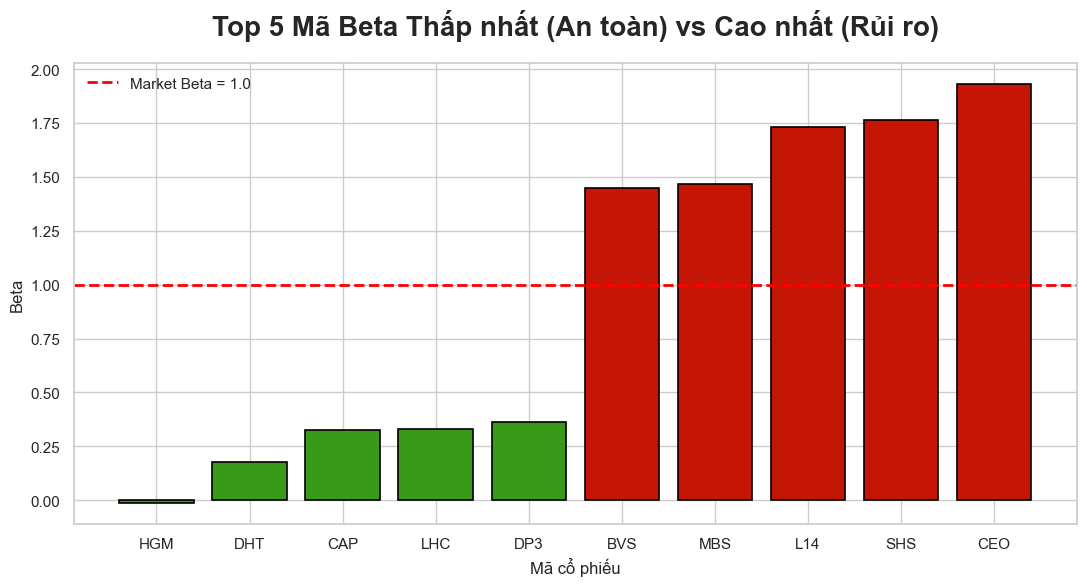

In [34]:
# =============================================================================
# PHÂN TÍCH CỔ PHIẾU THEO BETA
# =============================================================================
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 11
OUTPUT_FOLDER = "KET_QUA"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Đọc và xử lý dữ liệu
df_weekly = pd.read_excel("HNX30_HNXINDEX_gop.xlsx", sheet_name="Returns_Weekly")
df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])
df_weekly.set_index('Date', inplace=True)

df_bond = pd.read_excel("10ybondyield_filled.xlsx", sheet_name="Sheet1")
df_bond.set_index('Date', inplace=True)
df_bond = df_bond.sort_index()

rf_daily = df_bond[df_bond.columns[-1]] / 100
rf_daily = rf_daily[~rf_daily.index.duplicated(keep='last')]
rf_aligned = rf_daily.reindex(df_weekly.index, method='ffill').ffill().bfill()
rf_weekly = (1 + rf_aligned)**(1/52) - 1

# Tính Beta
market_ret = df_weekly['HNXINDEX']
market_excess = market_ret - rf_weekly
stocks = [c for c in df_weekly.columns if c != 'HNXINDEX']

betas = {}
for s in stocks:
    stock_excess = df_weekly[s] - rf_weekly
    temp = pd.DataFrame({'s': stock_excess, 'm': market_excess}).dropna()
    if len(temp) < 52: continue
    model = sm_stats.OLS(temp['s'], sm_stats.add_constant(temp['m'])).fit()
    beta = model.params[1]
    if abs(beta) <= 10:
        betas[s] = beta

# Top 5 Beta thấp và cao
sorted_betas = sorted(betas.items(), key=lambda x: x[1])
top5_low  = dict(sorted_betas[:5])
top5_high = dict(sorted_betas[-5:])

low_stocks  = list(top5_low.keys())
high_stocks = list(top5_high.keys())

port_low  = df_weekly[low_stocks].mean(axis=1)
port_high = df_weekly[high_stocks].mean(axis=1)

# Vẽ biểu đồ cột top 5 Beta
plt.figure(figsize=(11,6))
codes = list(top5_low.keys()) + list(top5_high.keys())
values = list(top5_low.values()) + list(top5_high.values())
colors = ["#399918"]*5 + ["#C51605"]*5

bars = plt.bar(codes, values, color=colors, edgecolor='black', linewidth=1.2)
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Market Beta = 1.0')
plt.title('Top 5 Mã Beta Thấp nhất (An toàn) vs Cao nhất (Rủi ro)', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Beta')
plt.xlabel('Mã cổ phiếu')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "1_Top5_Beta_Bar.png"), dpi=300, bbox_inches='tight')
plt.show()

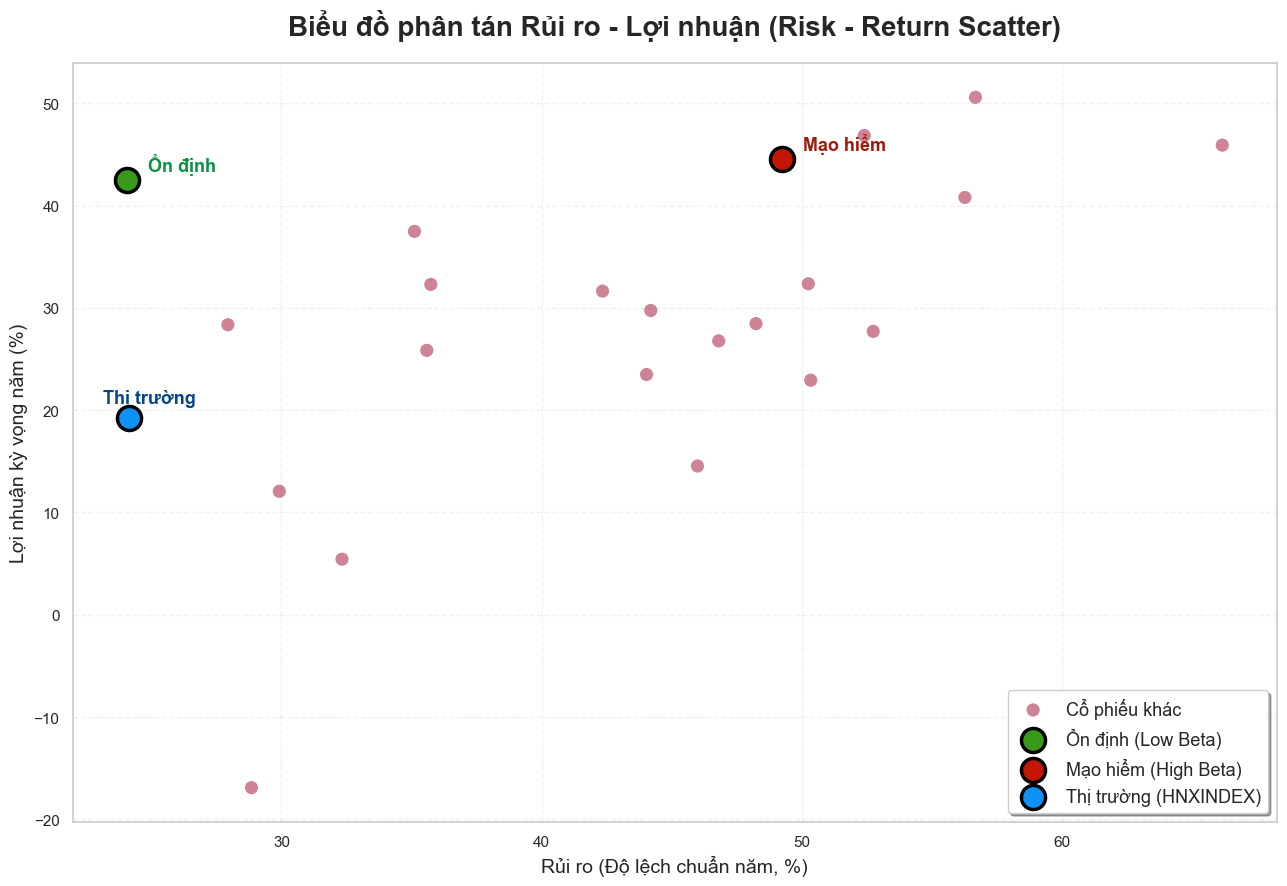

In [35]:
# =============================================================================
# BIỂU ĐỒ PHÂN TÁN RỦI RO - LỢI NHUẬN (RISK - RETURN SCATTER)
# =============================================================================
# Tính lợi nhuận và rủi ro cho TẤT CẢ cổ phiếu có Beta

individual_returns = df_weekly[list(betas.keys())].mean() * 52 * 100
individual_risks   = df_weekly[list(betas.keys())].std()  * np.sqrt(52) * 100  

# DataFrame chứa toàn bộ cổ phiếu
all_stocks_df = pd.DataFrame({
    'Stock': list(betas.keys()),
    'Beta' : list(betas.values()),
    'Return_%': individual_returns.values,
    'Risk_%'  : individual_risks.values,
    'Group'   : ['Top5 Low' if s in low_stocks else 
                 'Top5 High' if s in high_stocks else 
                 'Khác' for s in betas.keys()]
})

# Lợi nhuận & rủi ro của 2 danh mục và thị trường
ret_low_ann  = port_low.mean()  * 52 * 100
ret_high_ann = port_high.mean() * 52 * 100
ret_mkt_ann  = market_ret.mean() * 52 * 100

risk_low  = port_low.std()  * np.sqrt(52) * 100
risk_high = port_high.std() * np.sqrt(52) * 100
risk_mkt  = market_ret.std() * np.sqrt(52) * 100
# =============================================================================
# BIỂU ĐỒ RISK - RETURN SCATTER 
# =============================================================================
plt.figure(figsize=(13, 9))

# Tất cả các mã khác
plt.scatter(all_stocks_df[all_stocks_df['Group']=='Khác']['Risk_%'],
            all_stocks_df[all_stocks_df['Group']=='Khác']['Return_%'],
            color="#B03052", s=90, alpha=0.6, edgecolors='none', label='Cổ phiếu khác', zorder=1)

# Danh mục Ổn định (Top 5 Low Beta) 
plt.scatter(risk_low, ret_low_ann, s=300, c="#399918", marker='o', 
            edgecolors='black', linewidth=2.5, label='Ổn định (Low Beta)', zorder=5)


plt.text(risk_low + 0.8, ret_low_ann + 1.5, "Ổn định", 
         fontsize=13, fontweight='bold', color="#089342", ha='left', va='center')

# Danh mục Mạo hiểm (Top 5 High Beta) 
plt.scatter(risk_high, ret_high_ann, s=300, c="#C51605", marker='o', 
            edgecolors='black', linewidth=2.5, label='Mạo hiểm (High Beta)', zorder=5)


plt.text(risk_high + 0.8, ret_high_ann + 1.5, "Mạo hiểm",
         fontsize=13, fontweight='bold', color="#a0190a", ha='left', va='center')

# Thị trường HNX-Index 
plt.scatter(risk_mkt, ret_mkt_ann, s=300, c="#0D92F4", marker='o', 
            edgecolors='black', linewidth=2.5, label='Thị trường (HNXINDEX)', zorder=7)


plt.text(risk_mkt + 0.8, ret_mkt_ann +1.5, "Thị trường",
         fontsize=13, fontweight='bold', color="#044689", ha='center')

# Trang trí
plt.title('Biểu đồ phân tán Rủi ro - Lợi nhuận (Risk - Return Scatter)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Rủi ro (Độ lệch chuẩn năm, %)', fontsize=14)
plt.ylabel('Lợi nhuận kỳ vọng năm (%)', fontsize=14)
plt.legend(fontsize=13, loc='lower right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "3_Risk_Return_With_All_Stocks.png"), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

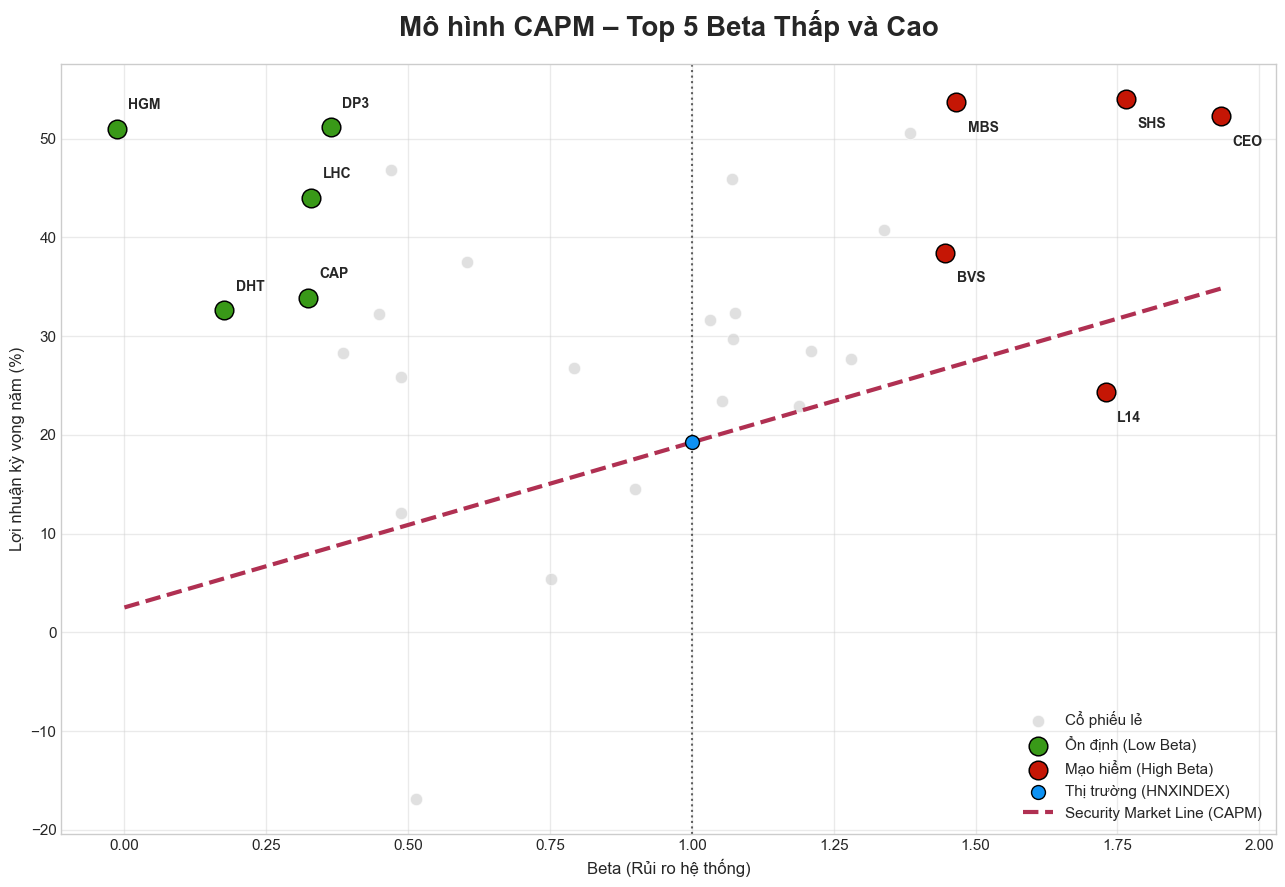

In [ ]:
# =============================================================================
# BIỂU ĐỒ CAPM - TOP 5 BETA THẤP VÀ CAO
# =============================================================================
rf_ann = rf_weekly.mean() * 52
mkt_ann = market_ret.mean() * 52
premium = mkt_ann - rf_ann

# Dữ liệu từng cổ phiếu
individual_ret = df_weekly[list(betas.keys())].mean() * 52 * 100

capm_df = pd.DataFrame({
    'Stock': list(betas.keys()),
    'Beta': list(betas.values()),
    'Return_%': individual_ret.values,
    'Group': ['Low' if s in low_stocks else 'High' if s in high_stocks else 'Other' for s in betas.keys()]
})

beta_line = np.linspace(0, max(capm_df['Beta'].max(), 1.5), 300)
sml_line = (rf_ann + beta_line * premium) * 100

plt.figure(figsize=(13,9))
# Cổ phiếu thường 
sns.scatterplot(data=capm_df[capm_df['Group']=='Other'], x='Beta', y='Return_%',
                color='lightgray', s=80, alpha=0.7, label='Cổ phiếu lẻ')

# Top 5 Low & High
sns.scatterplot(data=capm_df[capm_df['Group']=='Low'],  x='Beta', y='Return_%', color="#399918", s=180, edgecolor='black', label='Ổn định (Low Beta)')
sns.scatterplot(data=capm_df[capm_df['Group']=='High'], x='Beta', y='Return_%', color="#C51605", s=180, edgecolor='black', label='Mạo hiểm (High Beta)')

# Thị trường
plt.scatter(1, mkt_ann*100, color="#0D92F4", s=100, marker='o', edgecolor='black', label='Thị trường (HNXINDEX)', zorder=6)

# Đường SML
plt.plot(beta_line, sml_line, color="#B03052", linewidth=3, linestyle='--', label='Security Market Line (CAPM)')

# Ghi tên mã Top 10
for _, row in capm_df[capm_df['Group'] != 'Other'].iterrows():
    offset_y = 2 if row['Group']=='Low' else -3
    plt.text(row['Beta'] + 0.02, row['Return_%'] + offset_y, row['Stock'],
             fontsize=10, fontweight='bold')

plt.title('Mô hình CAPM – Top 5 Beta Thấp và Cao', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Beta (Rủi ro hệ thống)')
plt.ylabel('Lợi nhuận kỳ vọng năm (%)')
plt.axvline(1, color='black', linestyle=':', alpha=0.6)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "4_CAPM_Full_With_Stocks.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# =============================================================================
# XUẤT BẢNG BETA CỦA TẤT CẢ CỔ PHIẾU RA FILE EXCEL (THEO TUẦN)
# =============================================================================

print("\nĐang tính Beta tích lũy (toàn bộ lịch sử đến từng tuần) từ 2020–2025...")

# Lọc dữ liệu từ 2020 trở đi
df_filtered = df_weekly[df_weekly.index >= '2020-01-01'].copy()
rf_filtered = rf_weekly.reindex(df_filtered.index).ffill()

market_ret = df_filtered['HNXINDEX']
market_excess = market_ret - rf_filtered

stocks_valid = [s for s in df_filtered.columns if s != 'HNXINDEX']

# Tạo DataFrame kết quả: mỗi tuần một dòng, mỗi cổ phiếu một cột Beta
beta_expanding = pd.DataFrame(index=df_filtered.index, columns=stocks_valid)

# Tính Beta tích lũy cho từng cổ phiếu
for stock in stocks_valid:
    stock_ret = df_filtered[stock]
    stock_excess = stock_ret - rf_filtered
    
    betas = []
    for end_date in df_filtered.index:
        # Lấy tất cả dữ liệu từ đầu đến end_date (bao gồm cả end_date)
        mask = (df_filtered.index <= end_date)
        y = stock_excess[mask].dropna()
        x = market_excess[mask].dropna()
        
        # Tìm các ngày chung
        common_idx = y.index.intersection(x.index)
        if len(common_idx) < 30:  
            betas.append(np.nan)
            continue
            
        y_common = y.loc[common_idx]
        x_common = x.loc[common_idx]
        
        if x_common.std() < 1e-10:
            betas.append(np.nan)
        else:
            beta = np.cov(y_common, x_common)[0,1] / np.var(x_common)
            betas.append(beta if abs(beta) <= 10 else np.nan)  # loại beta cực đại
    
    beta_expanding[stock] = betas

# Bỏ những tuần đầu chưa có Beta (NaN)
beta_expanding = beta_expanding.dropna(how='all')

# Làm tròn & chuẩn bị xuất file
beta_expanding = beta_expanding.round(3)
beta_expanding = beta_expanding.reset_index().rename(columns={'Date': 'Ngày'})

# Tên file
file_name = "BETA_TICH_LUY_DAY_DU_2020_2025.xlsx"
path_ketqua = os.path.join(OUTPUT_FOLDER, file_name)
path_ngoai = os.path.join(".", file_name)  # thư mục gốc

# Xuất ra 2 nơi
beta_expanding.to_excel(path_ketqua, index=False, sheet_name='Beta_TichLuy')
beta_expanding.to_excel(path_ngoai,  index=False, sheet_name='Beta_TichLuy')


try:
    from openpyxl.styles import PatternFill, Font, Alignment
    from openpyxl.utils import get_column_letter

    for path in [path_ketqua, path_ngoai]:
        wb = openpyxl.load_workbook(path)
        ws = wb['Beta_TichLuy']

        header_fill = PatternFill(start_color="1f4e78", end_color="1f4e78", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)
        for cell in ws[1]:
            cell.fill = header_fill
            cell.font = header_font
            cell.alignment = Alignment(horizontal="center")

        ws.freeze_panes = 'B2'

        for i, col in enumerate(ws.columns, 1):
            max_len = 0
            column = get_column_letter(i)
            for cell in col:
                try:
                    if len(str(cell.value)) > max_len:
                        max_len = len(str(cell.value))
                except:
                    pass
            adjusted_width = min(max_len + 2, 20)
            ws.column_dimensions[column].width = adjusted_width

        wb.save(path)
    print("Đã làm đẹp file Excel (header xanh, đóng băng, căn chỉnh cột)")
except:
    pass

print("HOÀN TẤT TÍNH BETA TÍCH LŨY ĐẦY ĐỦ (2020–2025)")
print(f"File đã lưu ở 2 nơi:")
print(f"   → Thư mục gốc       : {path_ngoai}")
print(f"   → Thư mục KET_QUA   : {path_ketqua}")
print(f"   → Số cổ phiếu       : {len(stocks_valid)}")
print(f"   → Số tuần có Beta   : {len(beta_expanding)}")
# =============================================================================
# KẾT LUẬN
# =============================================================================
print("\n" + "="*85)
print("HOÀN TẤT! ĐÃ TẠO 4 BIỂU ĐỒ CHUYÊN NGHIỆP + DANH MỤC TOP 5")
print("="*85)
print(f"Ổn định (Low Beta) : {low_stocks}  | Lợi nhuận: {ret_low_ann:.1f}% | Rủi ro: {risk_low:.1f}%")
print(f"Mạo hiểm (High Beta): {high_stocks} | Lợi nh    uận: {ret_high_ann:.1f}% | Rủi ro: {risk_high:.1f}%")
print(f"Thị trường          : Lợi nhuận: {ret_mkt_ann:.1f}% | Rủi ro: {risk_mkt:.1f}%")
print("="*85)
print("Tất cả biểu đồ đã lưu vào thư mục KET_QUA:")
print("1_Top5_Beta_Bar.png | 2_Cumulative_Returns.png | 3_Risk_Return_Scatter.png | 4_CAPM_Full_With_Stocks.png")
print("="*85)


Đang tính Beta tích lũy (toàn bộ lịch sử đến từng tuần) từ 2020–2025...
Đã làm đẹp file Excel (header xanh, đóng băng, căn chỉnh cột)
HOÀN TẤT TÍNH BETA TÍCH LŨY ĐẦY ĐỦ (2020–2025)
File đã lưu ở 2 nơi:
   → Thư mục gốc       : .\BETA_TICH_LUY_DAY_DU_2020_2025.xlsx
   → Thư mục KET_QUA   : KET_QUA\BETA_TICH_LUY_DAY_DU_2020_2025.xlsx
   → Số cổ phiếu       : 30
   → Số tuần có Beta   : 278

HOÀN TẤT! ĐÃ TẠO 4 BIỂU ĐỒ CHUYÊN NGHIỆP + DANH MỤC TOP 5
Ổn định (Low Beta) : ['HGM', 'DHT', 'CAP', 'LHC', 'DP3']  | Lợi nhuận: 42.5% | Rủi ro: 24.1%
Mạo hiểm (High Beta): ['BVS', 'MBS', 'L14', 'SHS', 'CEO'] | Lợi nh    uận: 44.6% | Rủi ro: 49.3%
Thị trường          : Lợi nhuận: 19.2% | Rủi ro: 24.1%
Tất cả biểu đồ đã lưu vào thư mục KET_QUA:
1_Top5_Beta_Bar.png | 2_Cumulative_Returns.png | 3_Risk_Return_Scatter.png | 4_CAPM_Full_With_Stocks.png
Đã làm đẹp file Excel (header xanh, đóng băng, căn chỉnh cột)
HOÀN TẤT TÍNH BETA TÍCH LŨY ĐẦY ĐỦ (2020–2025)
File đã lưu ở 2 nơi:
   → Thư mục gốc       : .


           BÁO CÁO HIỆU QUẢ DANH MỤC ĐẦU TƯ - SHARPE RATIO & DRAWDOWN           

BẢNG XẾP HẠNG HIỆU QUẢ ĐẦU TƯ:
| Danh mục              |   Sharpe Ratio |   Beta trung bình | Max Drawdown (%)   | Lợi suất năm (%)   |
|:----------------------|---------------:|------------------:|:-------------------|:-------------------|
| Ổn định (Low Beta)    |          1.66  |             0.463 | -16.28%            | 42.51%             |
| Mạo hiểm (High Beta)  |          0.853 |             2.089 | -80.08%            | 44.57%             |
| Thị trường (HNXINDEX) |          0.693 |             1     | -61.56%            | 19.24%             |

→ Đã lưu báo cáo Excel: KET_QUA\BAOCAO_HIEUQUA.xlsx


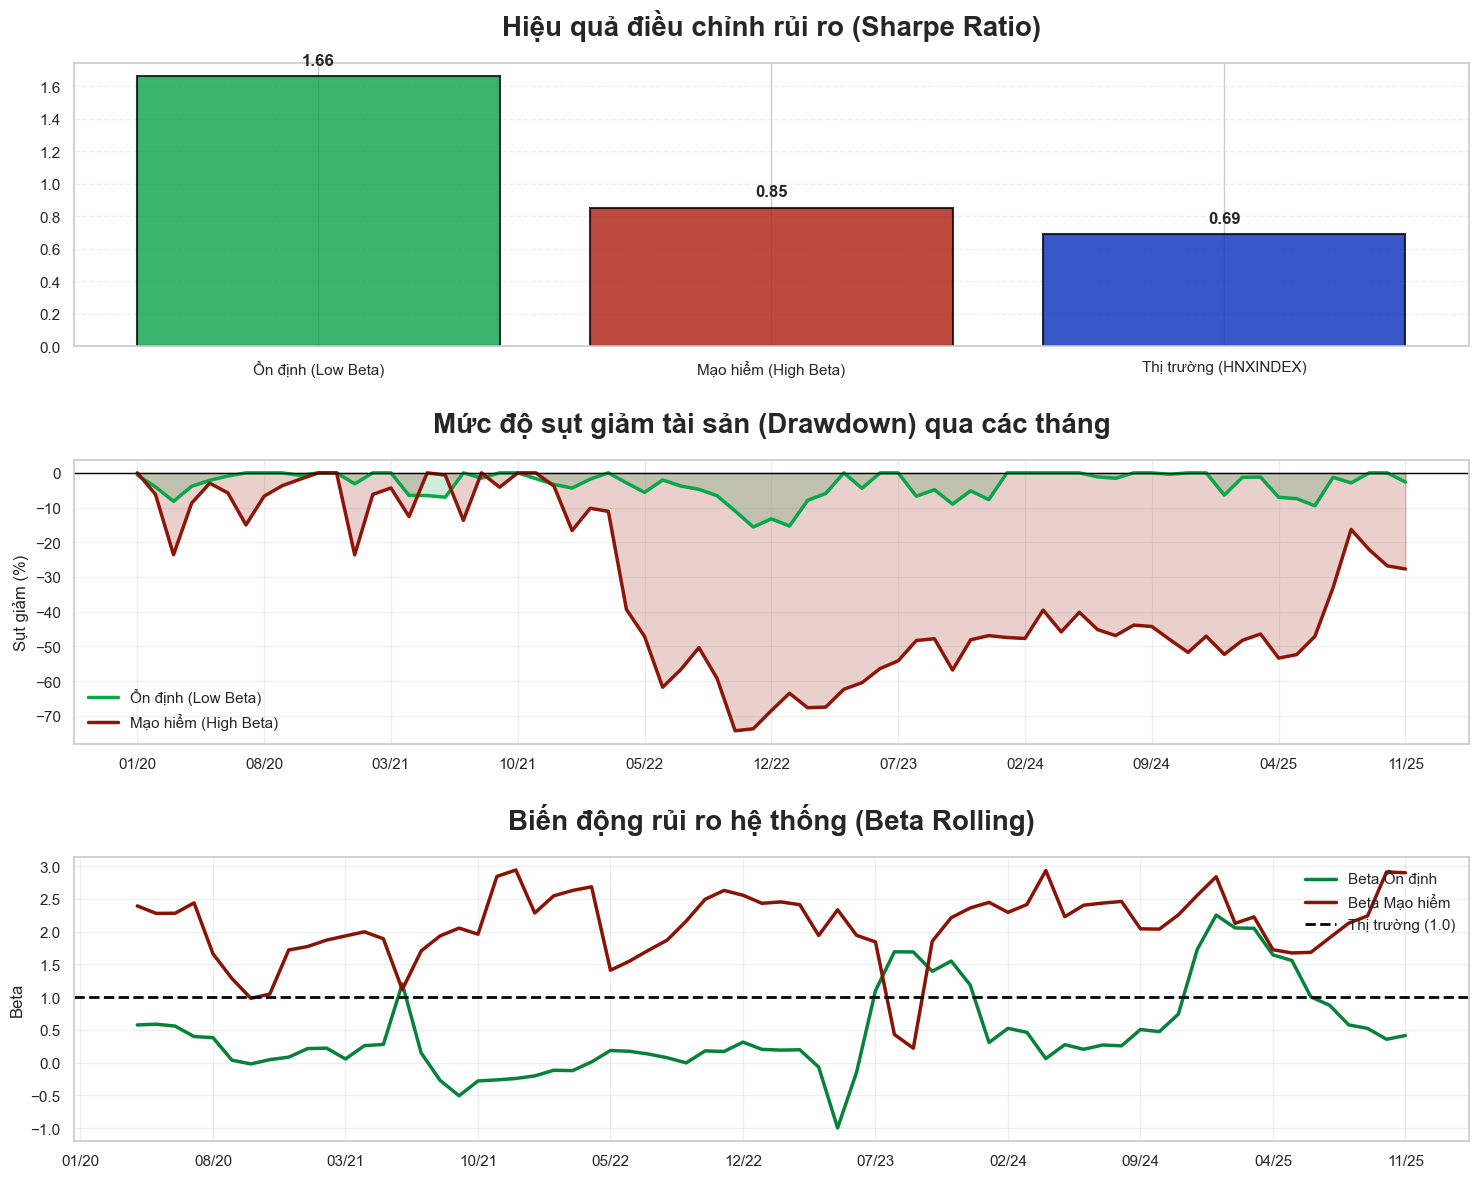

→ Đã lưu biểu đồ tổng hợp: KET_QUA\5_BaoCao_HieuQua_Full.png


In [ ]:
# =============================================================================
# BÁO CÁO HIỆU QUẢ CHUYÊN SÂU (SHARPE, DRAWDOWN, ROLLING BETA)
# =============================================================================
print("\n" + "="*80)
print("BÁO CÁO HIỆU QUẢ DANH MỤC ĐẦU TƯ - SHARPE RATIO & DRAWDOWN".center(80))
print("="*80)

# Hàm tính Sharpe Ratio
def calculate_sharpe(returns, rf):
    excess_ret = returns - rf
    if excess_ret.std() == 0: return 0
    return (excess_ret.mean() / excess_ret.std()) * np.sqrt(52)

# Kiểm tra biến từ code trước
if 'port_low' in globals() and 'port_high' in globals() and 'market_ret' in globals():

    # =====================================================
    # Tính Sharpe Ratio
    # =====================================================
    sharpe_low  = calculate_sharpe(port_low, rf_weekly)
    sharpe_high = calculate_sharpe(port_high, rf_weekly)
    sharpe_mkt  = calculate_sharpe(market_ret, rf_weekly)

    # =====================================================
    # Tính Drawdown (Sụt giảm tài sản)
    # =====================================================
    # Low Beta
    cum_low  = (1 + port_low).cumprod()
    dd_low   = cum_low / cum_low.cummax() - 1
    mdd_low  = dd_low.min() * 100
    
    # High Beta
    cum_high = (1 + port_high).cumprod()
    dd_high  = cum_high / cum_high.cummax() - 1
    mdd_high = dd_high.min() * 100
    
    # Market (Thêm vào để so sánh)
    cum_mkt  = (1 + market_ret).cumprod()
    dd_mkt   = cum_mkt / cum_mkt.cummax() - 1
    mdd_mkt  = dd_mkt.min() * 100

    # Drawdown theo tháng (để vẽ biểu đồ mượt hơn)
    dd_low_m  = (dd_low.resample('M').last() * 100).round(2)
    dd_high_m = (dd_high.resample('M').last() * 100).round(2)

    # =====================================================
    # Tính Beta Rolling 6 tháng
    # =====================================================
    # Gom dữ liệu lại
    weekly_data = pd.concat([port_low, port_high, market_ret], axis=1)
    weekly_data.columns = ['LowBeta', 'HighBeta', 'Market']
    weekly_data = weekly_data.dropna()

    # Chuyển sang return tháng để tính rolling 
    monthly_ret = weekly_data.resample('M').apply(lambda x: (1 + x).prod() - 1)

    window = 6
    beta_low_list  = []
    beta_high_list = []
    month_labels   = []

    for i in range(len(monthly_ret)):
        start_idx = max(0, i - window + 1)
        window_data = monthly_ret.iloc[start_idx:i+1]
        
        if len(window_data) >= 4:  # Yêu cầu ít nhất 4 tháng
            var_mkt  = np.var(window_data['Market'])
            if var_mkt > 0:
                cov_low  = np.cov(window_data['LowBeta'], window_data['Market'])[0][1]
                cov_high = np.cov(window_data['HighBeta'], window_data['Market'])[0][1]
                beta_l = cov_low / var_mkt
                beta_h = cov_high / var_mkt
            else:
                beta_l = beta_h = np.nan
        else:
            beta_l = beta_h = np.nan
            
        beta_low_list.append(round(beta_l, 3) if not np.isnan(beta_l) else np.nan)
        beta_high_list.append(round(beta_h, 3) if not np.isnan(beta_h) else np.nan)
        month_labels.append(monthly_ret.index[i].strftime('%Y-%m'))

    avg_beta_low  = round(np.nanmean(beta_low_list), 3)
    avg_beta_high = round(np.nanmean(beta_high_list), 3)

    # =====================================================
    # Bảng tổng hợp & Xác định Winner
    # =====================================================
    evaluation_df = pd.DataFrame({
        'Danh mục': ['Ổn định (Low Beta)', 'Mạo hiểm (High Beta)', 'Thị trường (HNXINDEX)'],
        'Sharpe Ratio': [sharpe_low, sharpe_high, sharpe_mkt],
        'Beta trung bình': [avg_beta_low, avg_beta_high, 1.00],
        'Max Drawdown (%)': [mdd_low, mdd_high, mdd_mkt],
        'Lợi suất năm (%)': [
            port_low.mean()*52*100,
            port_high.mean()*52*100,
            market_ret.mean()*52*100
        ]
    })

    # Sắp xếp theo Sharpe Ratio giảm dần
    evaluation_df = evaluation_df.sort_values('Sharpe Ratio', ascending=False).reset_index(drop=True)
    
    # Xác định Winner
    winner = evaluation_df.iloc[0]['Danh mục']

    # Format
    print_df = evaluation_df.copy()
    print_df['Sharpe Ratio'] = print_df['Sharpe Ratio'].round(3)
    print_df['Max Drawdown (%)'] = print_df['Max Drawdown (%)'].apply(lambda x: f"{x:.2f}%")
    print_df['Lợi suất năm (%)'] = print_df['Lợi suất năm (%)'].apply(lambda x: f"{x:.2f}%")
    
    print("\nBẢNG XẾP HẠNG HIỆU QUẢ ĐẦU TƯ:")
    print(print_df.to_markdown(index=False))

    # =====================================================
    # Lưu Excel
    # =====================================================
    drawdown_detail = pd.DataFrame({
        'Tháng': dd_low_m.index.strftime('%Y-%m'),
        'Ổn định - Low Beta (%)': dd_low_m.values,
        'Mạo hiểm - High Beta (%)': dd_high_m.values
    })

    beta_detail = pd.DataFrame({
        'Tháng': month_labels,
        'Beta Ổn định (Low Beta)': beta_low_list,
        'Beta Mạo hiểm (High Beta)': beta_high_list
    })

    eval_file = os.path.join(OUTPUT_FOLDER, "BAOCAO_HIEUQUA.xlsx")
    with pd.ExcelWriter(eval_file, engine='openpyxl') as writer:
        print_df.to_excel(writer, sheet_name='Tổng hợp', index=False)
        drawdown_detail.to_excel(writer, sheet_name='Drawdown theo tháng', index=False)
        beta_detail.to_excel(writer, sheet_name='Beta rolling 6T', index=False)
    
    print(f"\n→ Đã lưu báo cáo Excel: {eval_file}")

    # =====================================================
    # Vẽ biểu đồ Báo cáo (Dashboard)
    # =====================================================
    fig = plt.figure(figsize=(18, 14)) # Tăng chiều cao
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.4)

    # --- Biểu đồ 1: Sharpe Ratio (Cột) ---
    ax1 = fig.add_subplot(gs[0, 0])
    sharpe_colors = []
    for danh_muc in evaluation_df['Danh mục']:
        if 'Thị trường' in danh_muc:
            sharpe_colors.append("#072db9")  
        elif danh_muc == winner:
            sharpe_colors.append("#06a147")  
        else:
            sharpe_colors.append("#ad1d0d")  

    bars = ax1.bar(evaluation_df['Danh mục'], evaluation_df['Sharpe Ratio'],
                   color=sharpe_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax1.set_title('Hiệu quả điều chỉnh rủi ro (Sharpe Ratio)', fontsize=20, fontweight='bold', pad=20)
    ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Ghi số lên cột
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.05 if h>0 else h-0.1, 
                 f'{h:.2f}', ha='center', va='bottom' if h>0 else 'top', fontweight='bold', fontsize=12)

    # --- Biểu đồ 2: Drawdown (Vùng) ---
    ax2 = fig.add_subplot(gs[1, 0])
    months = np.arange(len(dd_low_m))
    
    # Vẽ Low Beta
    ax2.plot(months, dd_low_m, label='Ổn định (Low Beta)', color="#08a74a", linewidth=2.5)
    ax2.fill_between(months, dd_low_m, 0, color="#06a94a", alpha=0.2)
    
    # Vẽ High Beta
    ax2.plot(months, dd_high_m, label='Mạo hiểm (High Beta)', color="#8e1609", linewidth=2.5)
    ax2.fill_between(months, dd_high_m, 0, color="#931507", alpha=0.2)
    
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_title('Mức độ sụt giảm tài sản (Drawdown) qua các tháng', fontsize=20, fontweight='bold', pad=20)
    ax2.set_ylabel('Sụt giảm (%)')
    
  
    step = max(1, len(months)//10)
    ax2.set_xticks(months[::step])
    ax2.set_xticklabels(dd_low_m.index.strftime('%m/%y')[::step], rotation=0)
    
    ax2.legend(loc='lower left', fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)

    # --- Biểu đồ 3: Rolling Beta (Đường) ---
    ax3 = fig.add_subplot(gs[2, 0])
    valid_months = np.arange(len(beta_detail))
    
    ax3.plot(valid_months, beta_detail['Beta Ổn định (Low Beta)'], 
             label='Beta Ổn định', color="#07823a", linewidth=2.5, linestyle='-')
    ax3.plot(valid_months, beta_detail['Beta Mạo hiểm (High Beta)'], 
             label='Beta Mạo hiểm', color="#891306", linewidth=2.5, linestyle='-')
    
    ax3.axhline(1.0, color="#00060b", linestyle='--', linewidth=2, label='Thị trường (1.0)')
    ax3.set_title('Biến động rủi ro hệ thống (Beta Rolling)', fontsize=20, fontweight='bold', pad=20)
    ax3.set_ylabel('Beta')
    
    ax3.set_xticks(valid_months[::step])
    ax3.set_xticklabels(dd_low_m.index.strftime('%m/%y')[::step], rotation=0)
    
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    final_img = os.path.join(OUTPUT_FOLDER, '5_BaoCao_HieuQua_Full.png')
    plt.savefig(final_img, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"→ Đã lưu biểu đồ tổng hợp: {final_img}")

else:
    print("LỖI: Không tìm thấy dữ liệu danh mục (port_low, port_high). Hãy chạy code phần trên trước!")

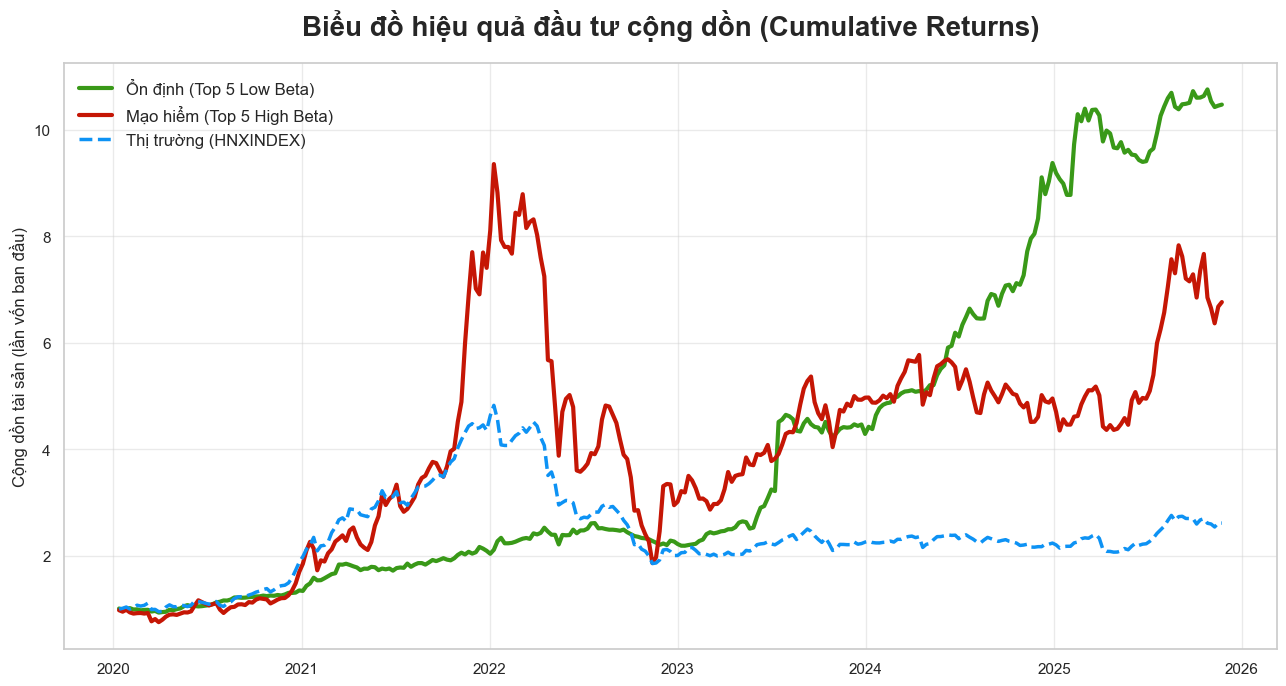

In [38]:
# =============================================================================
# BIỂU ĐỒ HIỆU QUẢ ĐẦU TƯ CỘNG DỒN (CUMULATIVE RETURNS)
# =============================================================================
cum_low  = (1 + port_low).cumprod()
cum_high = (1 + port_high).cumprod()
cum_mkt  = (1 + market_ret).cumprod()

plt.figure(figsize=(13,7))
plt.plot(cum_low,  label='Ổn định (Top 5 Low Beta)',  color="#399918", linewidth=3)
plt.plot(cum_high, label='Mạo hiểm (Top 5 High Beta)', color="#C51605", linewidth=3)
plt.plot(cum_mkt,  label='Thị trường (HNXINDEX)',      color="#0D92F4", linewidth=2.5, linestyle='--')
plt.title('Biểu đồ hiệu quả đầu tư cộng dồn (Cumulative Returns)', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Cộng dồn tài sản (lần vốn ban đầu)')
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "2_Cumulative_Returns.png"), dpi=300, bbox_inches='tight')
plt.show()